<center>
<hr>
<h1>INF-477. Redes Neuronales Artificiales.</h1>
<h2>Tarea 2 - Autoencoders, RBMs y ConvNets</h2>
<hr>
</center>

<div style="width:25%; display: inline-block"></div>
<div style="width:25%; display: inline-block">
    <b>Juan Carlos Garcés Bernt</b><br>
    jcgarces@alumnos.inf.utfsm.cl
</div>
<div style="width:25%; display: inline-block;">
    <b>Natalia Gonzalez</b><br>
    natalia.gonzalezg@usm.cl
</div>
<div style="width:25%; display: inline-block"></div>


<h1>1 Entrenamiento de Autoencoders (AEs) y RBMs en MNIST</h1>

Como hemos discutido en clases, las RBM's y posteriormente los AE's, fueron un componente crucial en el
desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con
logros notables de desempeño en diferentes tareas de aprendizaje automático.<br>
En esta sección aprenderemos a utilizar estos modelos en tres escenarios clásicos: reducción de dimensionalidad,
denoising y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado
*MNIST*, bastante conocido en el área e introducido por Yann LeCunn hacia 1998 en un trabajo que,
junto al Neocognitron de Fukushima, se considera uno de los principales antecedentes de las redes convolucionales
modernas. Se trata de una colección de $70.000$ imágenes de $28 \times 28$ pixeles correspondientes a
dígitos manuscritos (números entre $0$ y $9$). En su versión tradicional, la colección se encuentra separada en
dos subconjuntos: uno de entrenamiento de $60.000$ imágenes y otro de test de $10.000$ imágenes. La tarea
consiste en entrenar un programa para que aprenda a identificar correctamente el dígito representado en la
imagen.
<img src="img/Fig1.png">
<center>Fig. 1: Dataset MNIST y visualización obtenida usando las primeras dos componentes principales.</center>

a) Escriba una función que cargue los datos desde el repositorio de keras, normalice las imágenes de
modo que los pixeles queden en $[0, 1]$, transforme las imágenes en vectores $(\in \mathbb{R}^{784})$ y devuelva tres
subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. La normalización
permite interpretar cada valor como una probabilidad de "activación" del un pixel. El conjunto de
pruebas será aquel por defecto. Para la construcción del subconjunto de validación su función recibirá
un parámetro **NVAL**, cuyo valor por defecto será $1000$. El conjunto de validación se construirá utilizando
los últimos **NVAL** casos del conjunto del entrenamiento por defecto. El conjunto de entrenamiento
consistirá en las primeras $60000$ - **NVAL** imágenes.

In [2]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils #

nval =1000 #
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_train[-nval:]
y_val = y_train[-nval:]
x_train = x_train[:-nval]
y_train = y_train[:-nval]
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

<h2>1.1 Reducción de Dimensionalidad</h2>
Construir una representación de menor dimensionalidad de un objeto en $\mathbb{R}^d$, consiste en construir una función $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^{d'},$ con $d' \ll d$ que preserve lo mejor posible la "información" original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadístico (permite construir modelos con un menor número de parámetros libres). Una técnica de reducción de dimensionalidad se denomina *no super-visada* cuando no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento, marco de trabajo útil cuando dicha información no está disponible. Un AE y una RBM se pueden considerar métodos no-supervisados de reducción de dimensionalidad.

a) Entrene un AR básico (1capa escondida) para generar una representación de MNIST en $d' = 2,8,32,64$ dimensiones. Determine el porcentaje de compresión obtenido y el error de recontrucción en cada caso.
¿Mejora el resultado si elegimos una función de activación ReLU para el Encoder? ¿Podría utilizarse una ReLU en el decoder?

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

d_prima = [2,8,32,64]
for d in d_prima:
    print("MNIST d'="+str(d)+"...",end="")
    input_img = Input(shape=(784,))
    encoded       = Dense(d, activation='sigmoid')(input_img)
    decoded       = Dense(784, activation='sigmoid')(encoded)
    autoencoder   = Model(input=input_img, output=decoded)
    encoder       = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder       = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,verbose=0,shuffle=True,validation_data=(x_val, x_val))
    autoencoder.save('basic_autoencoder_768x'+str(d)+'.h5')
    print("OK\n")
    #save other stuff ...

MNIST d'=2...OK

MNIST d'=8...OK

MNIST d'=32...OK

MNIST d'=64...OK



b) Para verificar la calidad del modelo obtenido, compare visualmente la recontruscción que logra hacer el autoencoder desde la representación en $\mathbb{R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se correpsonde con el error de recontrucción observado. Comente.

= 	 2 	=


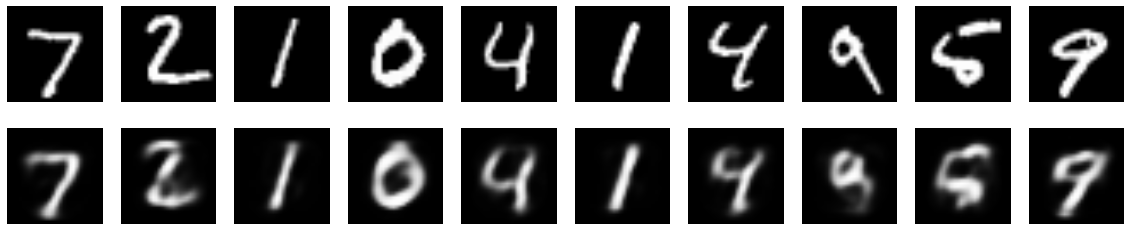

= 	 8 	=


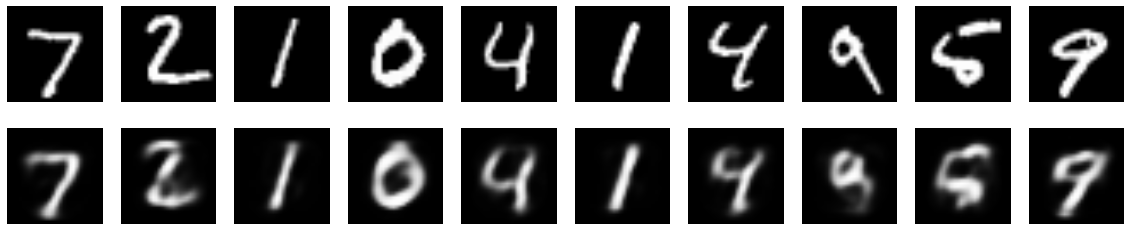

= 	 32 	=


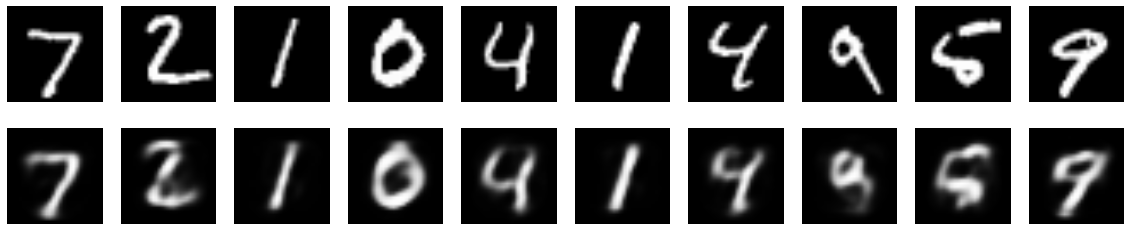

= 	 64 	=


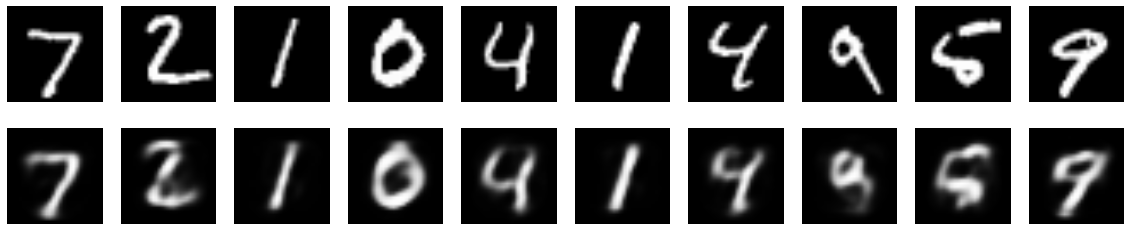

In [5]:
%matplotlib inline
from keras.models import load_model
from matplotlib import pyplot as plt

d_prima = [2,8,32,64]
for d in d_prima:
    print("=================")
    print("= \t",d,"\t=")
    print("=================")
    autoencoder = load_model('basic_autoencoder_768x'+str(d)+'.h5')
    #load other stuff ...
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    #import matplotlib
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

c) Para verificar la calidad de la representación obtenida, implemente el siguiente clasificador, denominado *kNN* (k-nearest neighbor): dada una imagen $x$, el clasificador busca las $k=10$ imágenes de entrenamiento más similares $N_{x} = \{ x^{(k_i)}\}_{i=1}^{10}$ (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes $N_x$. Mida el error de pruebas obtenido construyendo este clasificador sobre la data original y luego sobre la data reducida. Compare además los tiempos medios de predicción en ambos escenarios.

In [31]:
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
clf.fit(encoded_train, y_train)
score = clf.score(encoded_test,y_test)
print('Classification Accuracy %.2f' % score)

Classification Accuracy 0.96


d) Para verificar la calidad de la representación obtenida, implemente *k-means* (un método básico de
agrupamiento) sobre la representación obtenida por el autoencoder. Mida la calidad del agrupamiento
obtenido sobre los datos reducidos utilizando la métrica denominada ARI (*Adjusted Rand Index*) y
la función de desempeño (que llamaremos *clustering accuracy*) definida en el código de ejemplo que se
proporciona más abajo. Compare el resultado con el agrupamiento obtenido sobre los datos originales.

In [32]:
def clustering_accuracy(pred_labels,y,nclusters=10):
    true_pred = 0.0
    for i in range(0,nclusters):
        mvlabel = np.argmax(np.bincount(y[pred_labels==i]))
        true_pred += sum(y[pred_labels==i] == mvlabel)
    return true_pred/len(y)

from sklearn.cluster import KMeans
from sklearn import metrics
model = KMeans(n_clusters=10)
labels_pred = model.fit_predict(encoded_train)
score = metrics.adjusted_rand_score(y_train, labels_pred)
print ('Clustering ARI %.2f' % score)
print ('Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train))

Clustering ARI 0.38
Clustering ACC 0.59


e) $\star$ Compare la calidad de la representación reducida obtenida por el autoencoder básico con aquella
obtenida vía PCA utilizando el mismo número de dimensiones $d'$. Considere los $4$ criterios que hemos
utilizado hasta el momento, i.e., error de reconstrucción, visualización de la reconstrucción, desempeño
en clasificación (vía kNN) y desempeño en agrupamiento (vía kMeans). Comente.

In [33]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

d_prima = [2,8,32,64]
for d in d_prima:
    pca = PCA(n_components=d)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    score = clf.score(pca_test,y_test)
    print('PCA SCORE',d,' %.2f' % score)

PCA SCORE 2  0.44
PCA SCORE 8  0.90
PCA SCORE 32  0.97
PCA SCORE 64  0.97


f) Entrene una RBM binaria básica para generar una representación de MNIST en $d' = 2, 8, 32, 64$ dimensiones.
Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso.
Compare con los resultados obtenidos por el autoencoder utilizando los $3$ criterios que hemos utilizado
hasta el momento, i.e., error de reconstrucción, desempeño en clasificación (vía kNN) y desempeño en
agrupamiento (vía kMeans).

In [34]:
from sklearn.neural_network import BernoulliRBM
import numpy as np
import pickle ##to save trained models

d_prima = [2,8,32,64]
for d in d_prima:
    model = BernoulliRBM(n_components=d, batch_size=25,learning_rate=0.05,verbose=0, n_iter=50) ##n_components is d
    model.fit(x_train)##Train using persistent Gibbs chains
    fileo = open('basicRBM-'+str(d)+'.pickle','wb')
    pickle.dump(model,fileo)
    fileo.close()

g) $\star \star$ Modifique el autoencoder básico construido en (a) para implementar un *deep autoencoder* (deep
AE), es decir, un autoencoder con al menos dos capas ocultas. Demuestre experimentalmente que este
autoencoder puede mejorar significativamente la compresión obtenida por PCA utilizando el mismo
número de dimensiones $d'$. Experimente con $d' = 2, 4, 8, 16, 32$ y distintas profundidades ($L = 2, 3, 4$).
Considere en esta comparación los 3 criterios que hemos utilizado hasta el momento, i.e., error de
reconstrucción, desempeño en clasificación (vía kNN) y desempeño en agrupamiento (vía kMeans).
Comente.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

# ================ a =================


d_prima = [2,4,8,16,32]
for d in d_prima:
    print("=== MNIST d'="+str(d)+"===")
    
    target_dim = 2 #try other and do a nice plot
    input_img = Input(shape=(784,))
    
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(250, activation='relu')(encoded2)
    encoded4 = Dense(target_dim, activation='relu')(encoded3)
    
    decoded4 = Dense(250, activation='relu')(encoded4)
    decoded3 = Dense(500, activation='relu')(encoded3)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    
    autoencoder = Model(input=input_img, output=decoded1)
    encoder = Model(input=input_img, output=encoded3)
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True,validation_data=(x_val, x_val))
    autoencoder.save('my_autoencoder_784x1000x500x250x'+str(d)+'.h5')

    pca = PCA(n_components=target_dim)
    pca.fit(x_train)
    
    
    print("==================")
# ====================================



"""
target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True,
validation_data=(x_val, x_val))
autoencoder.save('my_autoencoder_768x1000x500x250x2.h5')

pca = PCA(n_components=target_dim)
pca.fit(x_train)
"""

h) Para el caso $d'=2$ de los experimentos anteriores, genere un gráfico que muestre la representación aprendida. Con este fin, utilice por ejemplo la herramienta de visualización TSNE disponible en *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA.

In [ ]:
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)

colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2:'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.figure(figsize=(10, 10))
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
#... plot PCA

i) Contruya una función que permita visualizar algunos de los pesos aprendidos por las neuronas de la primera capa del autoencoder. Muestre el resultado para las mejores redes conseguidas en los ítem anteriores.

j) Estudie como cambian los resultados del modelo construido en (a) si se impone simetría, es decir, si se trabaja con *tied weights*.

<h2>1.2 Denoising </h2>
Como hemos discutido en clases, un *denoising autoencoder* (dAE) es esencialmente un *autoencoder* entrenado
para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones latentes más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más "natural" o "directa" del método.

a) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $x \in \mathbb{R}^d$ es una de las imágenes originales, la versión ruidosa $\tilde x$ se obtiene como $\tilde x = x \odot \xi$ donde $\odot $ denota el producto de Hadamard ( componente a componente) y $\xi \in \mathbb{R}^d$ es un vector aleatorio binario con componentes Ber($p$) independientes.

In [ ]:
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

b) Entrene un autoencoder para recontruir las imágenes corruptas generadas en el ítem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de $p$ en el rango $(0,1)$

In [ ]:
# DEFINE YOUR AUTOENCODER AS BEFORE
autoencoder.fit(noisy_x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(noisy_x_val, x_val))

c) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido ( Gaussian noise): si $x \in \mathbb{R}^d$ es una de las imágenes originales, la versión ruidosa $\tilde x$ se obtiene como $\tilde = x + \xi$ donde $\xi \in \mathbb{R}^d$ esun vector aleatorio binario con componentes $N(0,\sigma ^{2})$

In [ ]:
from numpy.random import standard_normal
devst = 0.5
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)

noisy_x_val = x_val*noise_mask
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test*noise_mask

d) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ítem anterior. Mida el
error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida)
el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de $\sigma$ .

e) Escriba una función que permita visualizar los pesos aprendidos por el $dAE$ y compárelos con aquellos
aprendidos por un $AE$ ordinario. ¿Observa diferencias?

f) Suponga que su objetivo es aprender una representación de menor dimensionalidad del conjunto de ejemplos.
¿Es posible mejorar los resultados de reconstrucción obtenidos con un AE ordinario entrenándolo
con datos artificialmente corruptos? Proyecte un conjunto de experimentos que permita evaluar esta
hipótesis. Note que en este caso debe evaluar el AE sobre los datos de prueba no corruptos.

<h2>1.3 Pre.entrenamiento</h2>
En esta sección utilizaremos los modelos de las secciones anteriores (autoencoders y RBMs) para pre-entrenar
redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando
el modelo de partida en una buena zona del espacio de parámetros.

a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice BP sin ningún tipo
de pre-entrenamiento. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y funciones de
activación sigmoidales. Determine la *accuracy* (fracción de clasificaciones correctas) alcanzada por el
modelo en el conjunto de test.

In [ ]:
## PARAMETERS ...
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer1 = 'sigmoid'
decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50 
batch_size_ = 25

## Load and preprocess MNIST as usual
from keras.datasets import mnist
## HERE YOU NEED: Y_train,Y_val,Y_test produced in 1(a)

from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=50, batch_size=25,shuffle=True, validation_data=(x_val, Y_val))
model.save('ReluNet-768x1000x1000x10-NFT-50epochs.h5') #USEFUL WHEN TRAINING IS SLOW
#TRAINING CAN THEN BE RESUMED FROM THIS POINT :-)

b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la
arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico.
Proceda en modo clásico, es decir, entrenando en modo no-supervisado una capa a la vez y tomando
como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento
efectúe un entrenamiento supervisado convencional (*finetunning*). Compare los resultados de
clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe
también los resultados antes del *finetunning*. Comente.

In [ ]:
## Load and preprocess MNIST as usual
from keras.datasets import mnist

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,shuffle=True, validation_data=(x_val, Y_val))
model.save('Net-768x1000x1000x10-finetunned.h5')

c) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la
arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante una RBM binaria
básica. Compare los resultados con aquellos obtenidos en (a) y (b). Comente.

In [ ]:
from sklearn.neural_network import BernoulliRBM
rbm1 = BernoulliRBM(n_components=n_hidden_layer1, batch_size=25,learning_rate=0.05,verbose=1, n_iter=50)
rbm1.fit(x_train)##Train using persistent Gibbs chains
encoded_train1 = rbm1.transform(x_train)
encoded_val1 = rbm1.transform(x_val)
encoded_test1 = rbm1.transform(x_test)

rbm2 = BernoulliRBM(n_components=n_hidden_layer2, batch_size=25,learning_rate=0.05,verbose=1, n_iter=50)
rbm2.fit(encoded_train1)
encoded_train2 = rbm2.transform(encoded_train1)
encoded_val2 = rbm2.transform(encoded_val1)
encoded_test2 = rbm2.transform(encoded_test1)

d) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura
propuesta en (a) y pre-entrenando los pesos de cada capa mediante un *denoising autoencoder.*
Compare los resultados con aquellos obtenidos en (a), (b) y (c). Comente.

e)Evalúe el efecto de incorporar un regulador $\ell_{2}$ y/o $\ell_{1}$ (elija usted) al enternamiento de la red neuronal final. Comente.

f) $\star$ Repita los experimentos (a)-(d) utilizando funciones de activación $Tanh$ y $ReLU$. comente.

In [ ]:
## PARAMETERS ...
n_hidden_layer1 = 1000
activation_layer1 = 'relu'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer1 = 'relu'
decoder_activation_2 = 'sigmoid'

g) $\star \star$ Evalúe el efecto de cambiar el número de neuronas ocultas en cada capa del modelo. Por simplicidad y aún si no es la arquitectura óptima para este problema puede fijar el número de capas ocultas a $L=3$ y experimente, al menos, con un número de neuronas igual a $500, 1000, 2000, 4000$.

h) $\star \star$ Evalúe el efecto de aumentar la profundidad de $1, 2, 3$ niveles en el modelo. Por simplicidad y aún si no es la arquitectura óptima para este problema mantena fijo el número de neuronas ocultas. 

<h1>2 Aprendizaje Semi.Supervisado en NORB</h1>

Como hemos discutido en clases, uno de los problemas más relevantes a la hora de aplicar técnicas de aprendizaje
automático a problemas es reales es el requisito de disponer de un gran número de datos etiquetados,
es decir, ejemplos para los que se conoce la respuesta deseada del sistema. Un problema de aprendizaje para
el que existen pocos datos etiquetados y muchos datos no etiquetados se denomina *semi-supervisado*. En
esta sección, utilizaremos la idea de pre-entrenar una red en modo no supervisado para atacar problemas
de aprendizaje semi-supervisado. Con este objetivo en mente, trabajaremos con un dataset denominado
$NORB$, introducido en [9] y utilizado en [10], que corresponde a imágenes estéreo de juguetes clasificados en
$6$ categorías. Se tienen $291.600$ ejemplos de entrenamiento y $58.320$ ejemplos de pruebas.
<img src="img/Fig2.png">
<center>Fig. 2: Dataset NORB.</center>
Los datos asociados a esta actividad podrán ser obtenidos utilizando los siguientes comandos en la línea
de comandos (sistemas UNIX)
```
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_1
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_2
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_3
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_4
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_5
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_6
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_7
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_8
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_9
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_10
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_11
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_12
wget http://octopus.inf.utfsm.cl/~ricky/data_batch_13
```
Los primeros $10$ batches corresponden a los datos de entrenamiento y los últimos $2$ a los datos de pruebas. Los
archivos corresponden a diccionarios serializados de python y pueden ser "extraídos" utilizando la siguiente
función

In [ ]:
def unpickle(file):
    import cPickle
    fo = open(file, rb)
    dict = cPickle.load(fo)
    fo.close()
    return dict

Una vez extraído, cada diccionario contendrá $2$ elementos importantes: *data* y *labels*. El primer elemento
(*data*) es un matriz de $2048 \times n$ (numpy array). Cada columna de esa matriz corresponde a una imagen
estéreo de un juguete: los primeros $1024$ valores vienen de una de las cámaras/vistas y los siguientes $1024$ de
la otra. Por otro lado, el elemento (*labels*) del diccionario contiene una lista de $n$ valores enteros entre $0$ y $5$ que identifican las clases antes a las que pertenecen los juguetes.

a) Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema NORB
generando como salida: <br>
(i) dos matrices $X_{tr}, Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, <br>
(ii) dos matrices $X_t, Y_t$, correspondientes a las imágenes y etiquetas de pruebas, y finalmente<br>
(iii) dos matrices $X_v, Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de
validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser
extraído desde el conjunto de entrenamiento seleccionando $5.832$ casos de cada batch.

In [ ]:
def load_NORB_train_val(PATH):
    xtr = []
    ytr = []
    xval = []
    yval = []

    for b in range(1,11):
        f = os.path.join(PATH,'data_batch_%d' % (b, ))
        datadict = unpickle(f)
        X = datadict['data'].T
        Y = np.array(datadict['labels'])
        Z = np.concatenate((X,Y),axis=1)
        Z = np.random.shuffle(Z)
        xtr.append(Z[5832:,0:-1])
        ytr.append(Z[5832:,-1])
        xval.append(Z[:5832,0:-1])
        yval.append(Z[:5832,-1])

    Xtr = np.concatenate(xtr)
    Ytr = np.concatenate(ytr)
    Xval = np.concatenate(xval)
    Yval = np.concatenate(yval)
    del xtr,ytr,xval,yval
    return Xtr, Ytr, Xval, Yval

b) Construya una función que escale apropiadamente las imágenes antes de trabajar. Experimente escalando
linealmente los datos de tal forma que cada pixel quede en el intervalo $[-1,1]$ con el máximo y
mínimo valor observado en los extremos del intervalo. Evalúe más tarde la ventaja de centrar y escalar
los datos para que cada atributo (pixel) tenga desviación estándar $1$ y media nula.

c) Su objetivo será ahora evaluar el desempeño de una red FF en un escenario semi-supervisado. Para
ello simulará un situación en la que se tienen $n_s$ ejemplos de entrenamiento para los cuales se conoce
la etiqueta correcta y $n_{ns} = n_{tr} - n_s$ ejemplos para los cuales no se tiene esta información ($n_{tr}$ es el
número total de ejemplos de entrenamiento). Para empezar, deberá entrenar una red FF con salida
softmax para el problema NORB. Considere la inclusión de dos capas escondidas (de $4000$ y $2000$
unidades) y funciones de activación $relu$. Como parámetros de referencia considere: BP con tasa de
aprendizaje constante, función de pérdida *cross-entropy binaria*, y mini batches de tamaño $10$. Puede
utilizar el conjunto de validación para mejorar el entrenamiento. Construya un gráfico que muestre
cómo evoluciona el error de pruebas como función de $\theta_s = n_s/n_{tr}$. Experimente con $\theta_s = 0.1, 0.2,...1$.

d) Su objetivo será ahora construir un gráfico similar al anterior que muestre cómo evoluciona el error de pruebas como función de $\theta_s = n_s / n_{tr}$ cuando la red se pre-entrena utilizando los datos no supervisados. ¿Mejora el resultado con respecto a la red entrenada utilizando sólo los casos para los que se conoce la etiqueta? Experimente pre-entrenando con distintas estrategias ( por ejemplo AE's versus dAe's ó AE's versus RBM's).

e) Repita el experimento anterior cambiando las funciones de activación a $sigmoidales$ y $tanh$.